# State Farm Distracted Driver Detection 

Getting started with the [State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection) competition. We use [nolearn](https://github.com/dnouri/nolearn) and [Lasagne](https://github.com/Lasagne/Lasagne) for the neural network part.

The repository can be found [here](https://github.com/ottogroup/statefarm).

## Imports

In [1]:
%pylab inline
import matplotlib.pyplot as plt
from lasagne import layers, updates, nonlinearities
from nolearn.lasagne import NeuralNet
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_loss
from sklearn.cross_validation import LabelKFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
from src.data import load_train_data
from src.data import load_test_data
from src.data import make_submission
from src.netutils import CVTrainSplit
from src.netutils import RotateBatchIterator

## Load data

In [3]:
IMG_SHAPE = 64, 64

In [4]:
path = 'path-to-data'

The `load_train_data` function will return `X_train` and `y_train` with the correct shape. `drivers` contains the driver ids for the images.

In [5]:
X_train, y_train, drivers = load_train_data(path, grayscale=True, img_shape=IMG_SHAPE)

Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9


In [6]:
X_train.shape, y_train.shape, drivers.shape

((22424, 1, 64, 64), (22424,), (22424,))

In [7]:
X_train, y_train, drivers = shuffle(X_train, y_train, drivers, random_state=0)

## Show some images

Note: We cropped the images to get a square size. They contain mostly the right side of the original images, as that side seems to contain the most useful information.

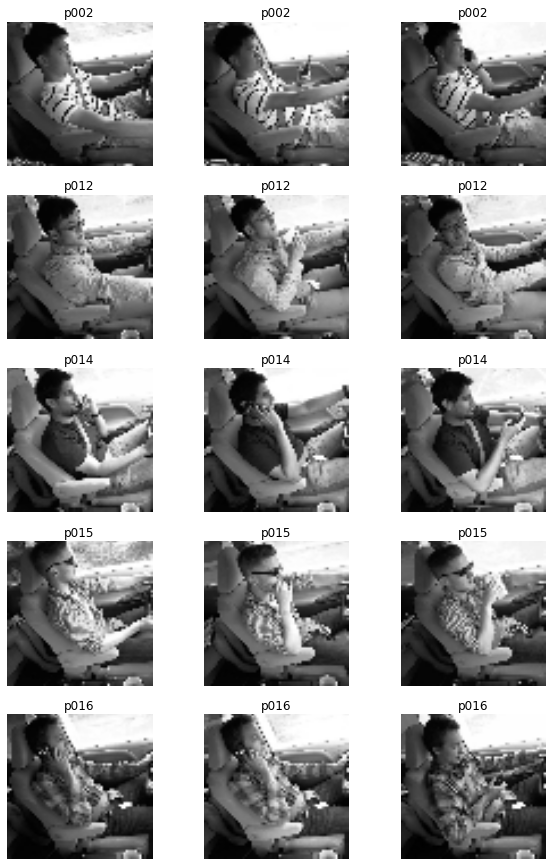

In [8]:
figs, axes = plt.subplots(5, 3, figsize=(10, 15))
[(ax.set_xticks([]), ax.set_yticks([]), ax.axis('off')) for ax in axes.flatten()]
for i, driver in enumerate(np.unique(drivers)[:5]):
    for j, n in enumerate(range(0, 300, 100)):
        axes[i, j].imshow(X_train[drivers==driver][n, 0], cmap='gray')
        axes[i, j].set_title(driver)

## Define the neural network

We pass a special train split to the `NeuralNet` instance so that the internal validation holds out 20% of the drivers for validation. This way, train and validation do not contain overlapping drivers. In practice, it is probably necessary to split several times for a more robust evaluation.

In [9]:
train_split = CVTrainSplit(LabelKFold(drivers, n_folds=5))

During training, we augment images by rotating them randomly in the range of -10 to 10 degrees. We rotate all images of a batch with a probability of 0.5.

In [16]:
batch_iterator_train = RotateBatchIterator(128, max_angle=10, rotate_prob=0.5)

The architecture is chosen to be not too deep for quick results. We use a lot of dropout layers and only one dense layer to combat overfitting, which is a huge problem in this competition.

In [17]:
layer = [
    (layers.InputLayer, {'shape': (None, X_train.shape[1], X_train.shape[2], X_train.shape[3])}),
    (layers.Conv2DLayer, {'num_filters': 32, 'filter_size': 3, 'pad': 'same'}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),
    (layers.DropoutLayer, {}),
    (layers.Conv2DLayer, {'num_filters': 64, 'filter_size': 3, 'pad': 'same'}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),
    (layers.DropoutLayer, {}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3, 'pad': 'same'}),
    (layers.MaxPool2DLayer, {'pool_size': 8}),
    (layers.DropoutLayer, {}),
    (layers.DenseLayer, {'num_units': 10, 'nonlinearity': nonlinearities.softmax})
]

In [18]:
net = NeuralNet(
    layers=layer, 
    update=updates.adam,
    update_learning_rate=0.001,
    verbose=1,
    batch_iterator_train=batch_iterator_train,
    train_split=train_split,
    max_epochs=50,
)

## Train

In [19]:
net.fit(X_train, y_train)

# Neural Network with 97802 learnable parameters

## Layer information

  #  name        size
---  ----------  ---------
  0  input0      1x64x64
  1  conv2d1     32x64x64
  2  maxpool2d2  32x32x32
  3  dropout3    32x32x32
  4  conv2d4     64x32x32
  5  maxpool2d5  64x16x16
  6  dropout6    64x16x16
  7  conv2d7     128x16x16
  8  maxpool2d8  128x2x2
  9  dropout9    128x2x2
 10  dense10     10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.29733       2.27301      1.01070      0.16754  34.30s
      2       2.14525       2.02573      1.05900      0.26405  34.49s
      3       1.88556       1.79979      1.04766      0.35637  34.80s
      4       1.61411       1.56883      1.02886      0.48665  36.55s
      5       1.31526       1.45095      0.90649      0.55420  34.05s
      6       1.13426       1.29661      0.87479      0.59125  35.64s
      7       0.97603       1.20484      0.

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f6da2cd4978>,
     batch_iterator_train=<src.netutils.RotateBatchIterator object at 0x7f6d42a5fe10>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 64, 64)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'pad': 'same', 'num_filters': 32, 'filter_size': 3}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': 2}), (<class 'lasagne.layers.noise.DropoutLayer'>, {}), (...layers.dense.DenseLayer'>, {'num_units': 10, 'nonlinearity': <function softmax at 0x7f6d627b72f0>})],
     loss=None, max_epochs=50, more_params={},
     objective=<function objective at 0x7f6d626ca400>,
     objective_loss_function=<function categorical_crossentropy at 0x7f6d62781840>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f6d42a1c8d0>],
     on_training_finished=[],
     on_trai

## Analysis

### Plot loss functions

This allows us to visualize the extent of overfit and whether the loss has converged.

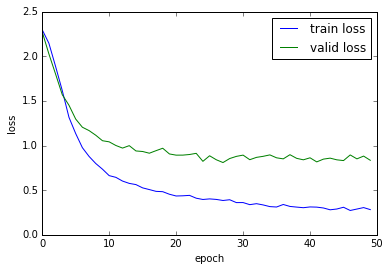

In [20]:
plot_loss(net)

### Critical image parts

This plot allows us to check which part of the image are most critical for making correct predictions. Does the net focus on important aspects such as the hand or face, or does it overfit on noise, such as the window?

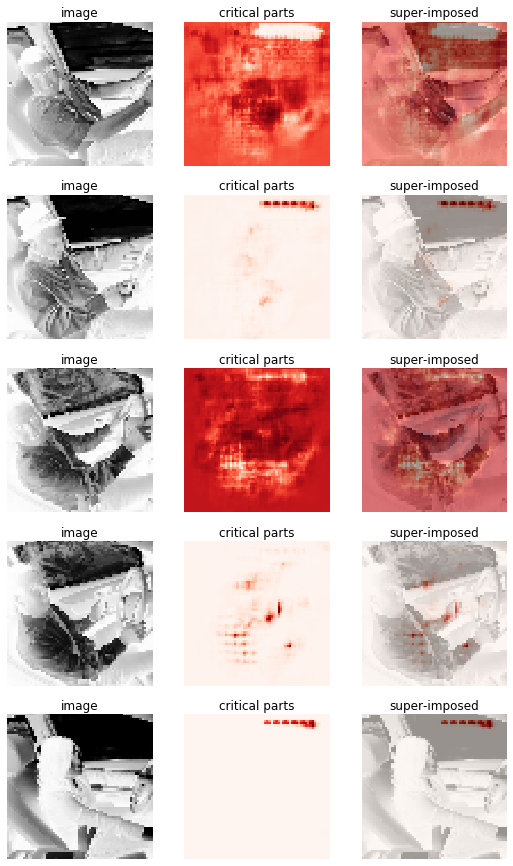

In [21]:
plot_occlusion(net, X_train[:5], y_train[:5])

### Confusion matrix

Here we check what classes the model struggles with predicting correctly.

In [22]:
_, X_valid, _, y_valid = net.train_split(X_train, y_train)

In [23]:
y_pred = net.predict(X_valid)

In [24]:
labels = [
    'safe driving',
    'texting - right',
    'talking on the phone - right',
    'texting - left',
    'talking on the phone - left',
    'operating the radio',
    'drinking',
    'reaching behind',
    'hair and makeup',
    'talking to passenger']

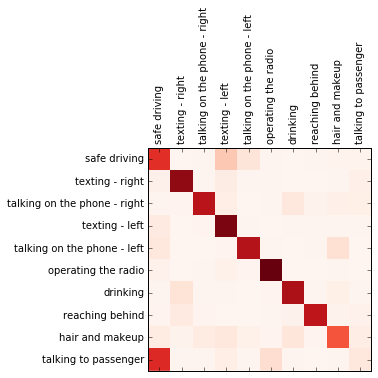

In [25]:
plt.matshow(confusion_matrix(y_valid, y_pred), cmap='Reds', interpolation='none')
plt.yticks(np.arange(10), labels)
plt.xticks(np.arange(10), labels, rotation=90);

## Submission

Finally, we prepare a submission to Kaggle.

In [ ]:
X_test, ids = load_test_data(path, grayscale=True, img_shape=IMG_SHAPE)

In [ ]:
y_proba = net.predict_proba(X_test)

In [ ]:
make_submission('submissions/submission_01.csv', y_proba, ids)

## Further avenues

There is a clear path for further improving the score:
* Take larger and/or colored images (set `grayscale=False` when loading images).
* Use a better architecture -- a deeper net will probably yield better results.
* Augment images to combat overfitting.